In [1]:
import numpy as np
import pandas as pd
import geopandas
import xarray as xr

from rasterio import features
from affine import Affine

import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = (12,8)


In [2]:
"""
These functions are for the NBR (normalised burn ratio) differencing technique.
"""

def _forward_fill(Input_DataArray = None):
    """
    - backfills all NAN values with the last non-nan value in the xr.DataArray
    - this step is necessary, because the differencing technique gives misleading results when NAN values are present


    INPUT:
    - Input_DataArray must be a xarray DataArray
    """
    temp_array = Input_DataArray
    
    for i in np.arange(0,len(temp_array.time)):
        temp_array = temp_array.fillna(temp_array.shift(time=1))
    
    return(temp_array)


def _identify_burned_area(Input_DataArray,lag0_threshold = -0.50, lag1_threshold = -0.3):
    """
    - calculates dNBR (difference in NBR between consecutive non-NAN values)
    - creates a burn mask (0: unburned, 1: burned) which satisfies two conditions:
        i) lag0_threshold: dNBR between time = t and time = t-1 exceeds this threshold
            - this catches all pixels which experience a sufficiently large drop in NBR 
            
        ii) lag1_threshold: dNBR between time = t+1 and time = t-1 exceeds this threshold
            - this catches all pixels in which a sufficiently large drop in NBR persists for at least one 
            additional timestep (this attempts to filter out erronous single values) 
    """
    
    A = _forward_fill(Input_DataArray)
    B1 = A - A.shift(time=1)
    B2 = A.shift(time=-1)-A.shift(time=1)
    
    C = B1.where(B1 < lag0_threshold)
    D = (B1 < lag0_threshold) & (B2 < lag1_threshold)
    
    return D

In [3]:
def transform_from_latlon(lat, lon):
    """
    This function is used for rasterising the shapefile
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape, transform = transform,
                                fill=fill, all_touched = True,
                                dtype=float, **kwargs)
    
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))




default_shapefile_filepath = "/home/603/rp1375/Desktop/Link to project/Burn_Mapping/02_Fire_Perimeters_Polygons/Victoria_FIRE_HISTORY/FIRE_HISTORY_2003_2018.shp"
default_reference_DataArray = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/SeverityMapping/BlackSaturday_BurnPixel_VIC_original_2005_2010.nc')

def _CreateValidatedBurnMask(shapefile_filepath = default_shapefile_filepath, 
                             reference_DataArray = default_reference_DataArray ):
    """
    This function creates a validation mask from an input shapefile. This validation mask is in xarray DataArray format,
    with dimensions and coordinates consistent with the reference_DataArray (i.e. the one you wish to test).
    
    Given the various shapefile formats (different attribute headers), some manual manipulation is required when 
    working with different shapefiles from different States/Territories (see below)

    
    #########Input#########
    'shapefile_filepath' must be a file path
    'reference_DataArray' must be a xr.DataSet or xr.DataArray. i.e. it must already be opened with xr.open_dataset etc.
    
    #########Output#########    
    xarray DataArray burn mask (0: unburned, 1: burned).
    Dimesions are: lat/lon/time
     - lat/lon are self-explanatory
     - time is the date of the particular fire event
    
    """
    
    assert type(shapefile_filepath) is str, 'shapefile_filepath must be a filepath string'
    

    ############## 1) Load in the Shapefile and crop to the correct extent  ##########
    #define location of Shapefile
    df = geopandas.read_file(shapefile_filepath)
    
    """
    These CRS's *may* require changing, if the input shapefile or reference_DataArray has a different CRS to what
    is stated below...
    
    TO-DO:
    - automatically detect CRS from shapefile and reference_DataArray to avoid problems...
    """
    #define projection of shapefile 
    df.crs = {'init' :'epsg:4283'}    
    #Convert to same projection as the input netcdf DataArray
    df = df.to_crs({'init': 'epsg:3577'})
    
    
    """
    This section reads the 'burn date' from the shapefile. In QGIS this information is contained in the attributes
    table - however, the columns headers are not consistent across shapefiles...
    
    So depending on which shapefile is currently being used, you need to uncomment the correct lines below:
    
    TO-DO:
    - merge all the shapefiles into one, and use a consistent column naming convention to avoid this problem...
    """
    
    #format shapefile attributes to datetime64 format
#   df.IGN_DATE = df.IGN_DATE.astype('datetime64[ns]')                             # Tasmania
#   df.ENDDATE = df.ENDDATE.astype('datetime64[ns]')                               # Mt David SF
    df.START_DATE = df.START_DATE.astype('datetime64[ns]')                         # VIC

    x_extent = [reference_DataArray.x.min() , reference_DataArray.x.max()]
    y_extent = [reference_DataArray.y.min() , reference_DataArray.y.max()]
    df = df.cx[ x_extent[0]:x_extent[1] , y_extent[0]:y_extent[1]]

    ####OPTIONAL EXTRA CONSTRAINTS
    #subset fire events by date:
#   df = df[df.IGN_DATE > '2003-01-01']                                            # Tasmania
#   df = df[df.ENDDATE > '2003-01-01']                                             # Mt David SF
    df = df[(df.START_DATE > '2009-02-01') & (df.START_DATE < '2009-03-30')]       # VIC
    
    
    ############## 2) Convert to Xarray DataArray using the coordinates from 'reference_DataArray' ##########
    try:
        del(output_array)
    except NameError:
        pass
    
    coords = reference_DataArray[['x','y']].coords

    for date in np.unique(df.START_DATE):
        shapes = [(shape,1) for  n, shape in enumerate(df[df.START_DATE == date].geometry)]
        
        try:
            new_da = rasterize(shapes , coords)
            new_da = new_da.assign_coords(time = date)
            new_da = new_da.expand_dims('time')
            output_array = xr.concat((output_array,new_da), dim='time')
  
        except NameError:
            output_array = rasterize(shapes , coords)
            output_array = output_array.assign_coords(time = date)
            output_array = output_array.expand_dims('time')

    
    return(output_array)


In [4]:
def _plot_RGB(xarray_dataset = None):
    """
    Simple function for plotting as RGB using xarray.plot.imshow() method.
    
    """
    
    rgb = xarray_dataset[['red','green','blue']]
    rgb = rgb.to_array(dim='color',name=None)
    
    fake_saturation = 2000
    
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow
    rgb.plot.imshow(x='x',y='y', col='time', col_wrap=3, add_colorbar=False)

In [5]:
def validate(Test_Array = None, Validated_Array = None, plot=False):
    """
    This function validates the Test_Array against the Validated_Array.
    It then calculates the desired validation metrics.
    
    To create ROC Curves, run this function multiple times, iterating over the range of threshold values. 
    
    
    ##############    
    Inputs:
    ----------------------
        Test_Array is an xarray DataArray with values 0 and 1 
        Validated_Array is an xarray DataArray with values 0 and 1 
    
        Plot = True/False : if True, output includes a plot showing Correct/Omission/Comission
    
    """
    
    import xarray
    assert type(Test_Array) is xarray.core.dataarray.DataArray, 'Test_Array not an xarray DataArray'
    assert type(Validated_Array) is xarray.core.dataarray.DataArray, 'Validated_Array not an xarray DataArray'

    
    # Classify as Correct/Omission/Comission
    Correct = Validated_Array.where(Validated_Array==1).where(Test_Array==1)
    Correct = Correct.fillna(0)
    Omission = Validated_Array.where(Validated_Array==1).where(Test_Array==0)
    Omission = Omission.fillna(0)
    Commission = Validated_Array.where(Validated_Array==0).where(Test_Array==1)+1
    Commission = Commission.fillna(0)
    
    Combined = Correct + Omission + Commission
    Combined = Combined.where(Combined.values!=0)
    
    # Calculate number of pixels in each category    
    e11 = Correct.sum(('x','y')).values                       # True Positives
    e12 = Commission.sum(('x','y')).values                    # False Positives
    e21 = Omission.sum(('x','y')).values                      # False Negatives
    e22 = len(Combined.x)*len(Combined.y) - e11 - e12 - e21
    
    # Checksum (all values must be positive)
    assert e11 >= 0, 'e11 error metrics invalid' 
    assert e12 >= 0, 'e12 error metrics invalid' 
    assert e21 >= 0, 'e21 error metrics invalid' 
    assert e22 >= 0, 'e22 error metrics invalid' 
    
    commission_error_ratio = e12/(e11+e12)
    omission_error_ratio = e21/(e11+e21)
    dice_coeff = (2*e11)/(2*e11+e12+e21)
    bias = e12 - e21
    
    #
    TPR = e11/(e11+e21) # True Positive Ratio
    FPR = e12/(e12+e22) # False Positive Ratio
    
    metrics = {'commission_error_ratio': commission_error_ratio,
               'omission_error_ratio': omission_error_ratio,
               'dice_coeff': dice_coeff,
               'bias': bias
              }
    
    
    # FOR PLOTTING ONLY
    if plot==True:
        Correct = Validated_Array.where(Validated_Array==1).where(Test_Array==1)+2
        Correct = Correct.fillna(0)
        Omission = Validated_Array.where(Validated_Array==1).where(Test_Array==0)+1
        Omission = Omission.fillna(0)
        Commission = Validated_Array.where(Validated_Array==0).where(Test_Array==1)+1
        Commission = Commission.fillna(0)
        
        Combined = Correct + Omission + Commission
        Combined = Combined.where(Combined.values!=0)

        from matplotlib.colors import ListedColormap
        cMap = ListedColormap(['white','blue', 'red','green'])
        Combined.plot(levels=[0,1, 2, 3, 4], cmap=cMap)

    return([FPR,TPR])
    

In [6]:
Validation_Mask = _CreateValidatedBurnMask()
Validation_Mask = Validation_Mask.sel(time=slice('2009-02','2009-04')).sum('time')

I am densified (external_values, 44980 elements)


In [7]:
# Load in the various Test_Arrays:

BlackSaturday_BurnPixel_VIC_MC_2005_2010 = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/SeverityMapping/BlackSaturday_BurnPixel_VIC_MC_2005_2010.nc')
BlackSaturday_BurnPixel_VIC_MC_2005_2010 = BlackSaturday_BurnPixel_VIC_MC_2005_2010.Severity

BlackSaturday_BurnPixel_VIC_original_2005_2010 = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/SeverityMapping/BlackSaturday_BurnPixel_VIC_original_2005_2010.nc')
BlackSaturday_BurnPixel_VIC_original_2005_2010 = BlackSaturday_BurnPixel_VIC_original_2005_2010.Severity

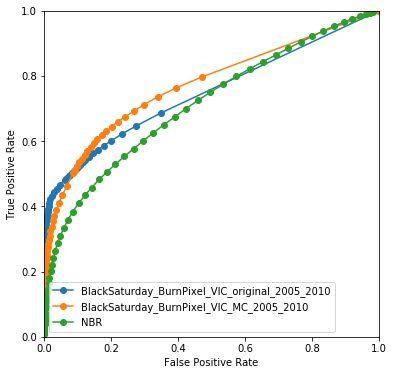

In [8]:
"""
This section creates ROC curves for each Test_array by iterating the validate function over the range of threshold values
"""

# Test_array 1: BlackSaturday_BurnPixel_VIC_original_2005_2010
scatter = []
plt.figure(figsize=(6,6))
for i in BlackSaturday_BurnPixel_VIC_original_2005_2010.level.values:
    X = validate(Test_Array=BlackSaturday_BurnPixel_VIC_original_2005_2010.sel(level=i),Validated_Array=Validation_Mask)
    scatter = np.concatenate((scatter,X),axis=0)
scatter = scatter.reshape((66,2))
plt.plot(scatter[:,0], scatter[:,1], '-o')


# Test_array 2: BlackSaturday_BurnPixel_VIC_MC_2005_2010
scatter = []
for i in BlackSaturday_BurnPixel_VIC_MC_2005_2010.level.values:
    X = validate(Test_Array=BlackSaturday_BurnPixel_VIC_MC_2005_2010.sel(level=i),Validated_Array=Validation_Mask)
    scatter = np.concatenate((scatter,X),axis=0)
scatter = scatter.reshape((66,2))
plt.plot(scatter[:,0], scatter[:,1], '-o')


# Test_array 2: NBR Differencing technique
data = xr.open_dataset('/home/603/rp1375/Desktop/Link to project/Burn_Mapping/01_LS_Reflectance_and_Indices/BlackSaturday_NBAR_ls5.nc')
data = data.sel(time='2009')
NBR = (data.nir - data.swir1) / (data.nir + data.swir1)
goodmask = np.isfinite(NBR).sum(dim=('x','y'))/(len(NBR.x)*len(NBR.y))>0.8
NBR = NBR.sel(time = goodmask)

scatter = []
for i in np.arange(-0.75,0,0.0125):
    NBR_Burn_Area = _identify_burned_area(NBR, lag0_threshold=i, lag1_threshold=i/3).max('time')
    X = validate(Test_Array=NBR_Burn_Area,Validated_Array=Validation_Mask)
    scatter = np.concatenate((scatter,X),axis=0)
scatter = scatter.reshape((60,2))
plt.plot(scatter[:,0], scatter[:,1], '-o')



plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['BlackSaturday_BurnPixel_VIC_original_2005_2010','BlackSaturday_BurnPixel_VIC_MC_2005_2010','NBR'])


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


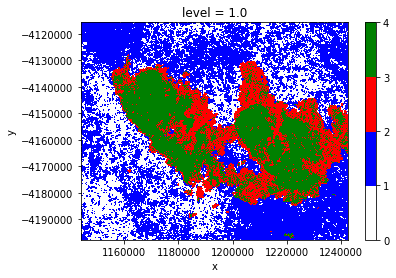

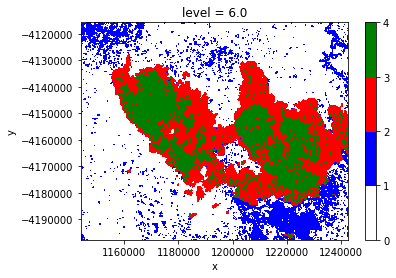

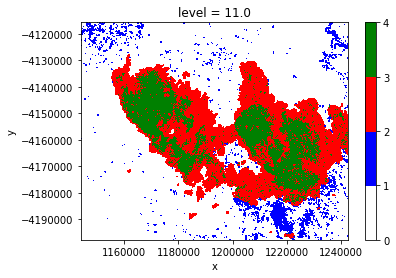

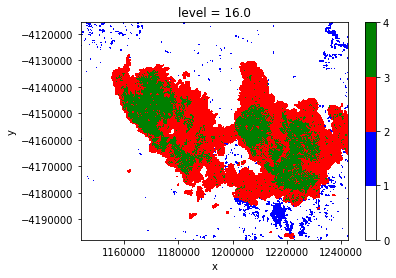

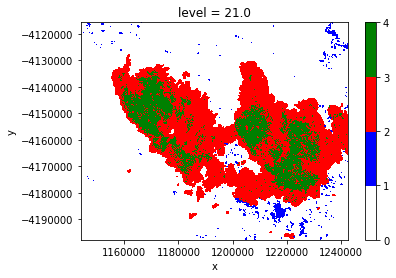

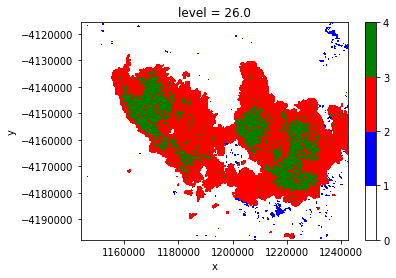

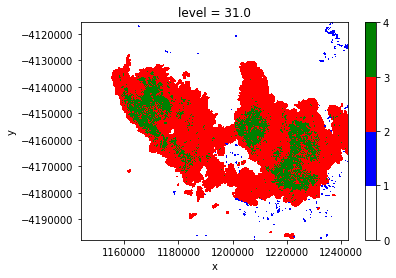

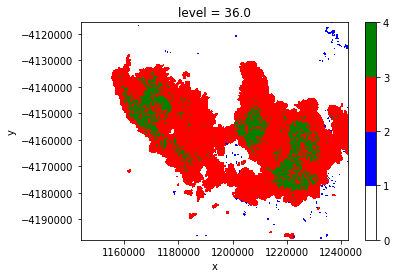

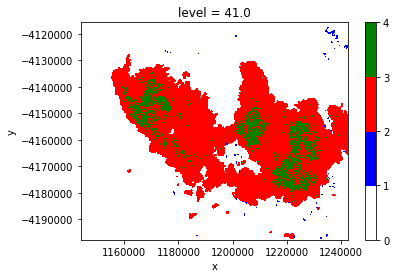

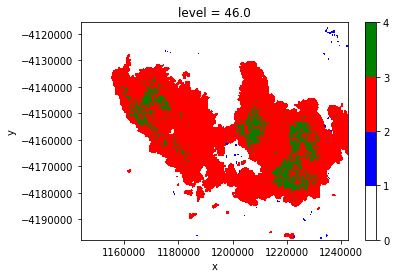

In [9]:
"""
If you wish to plot the results for a bunch of threshold values...

Here the .sel(level=i) is used to choose between threshold values, it could just as easily be used to select 
time if desired.

NOTE:
Green - Correctly identified as burned
Red - Omission: identified as unburned, but designated burned in Validation data
Blue - Comission: identified as burned, but designated unburned in Validation data
White - Correctly identified as unburned
"""

for i in range(1,50,5):
    plt.figure(i)
    validate(Test_Array=BlackSaturday_BurnPixel_VIC_original_2005_2010.sel(level=i),Validated_Array=Validation_Mask, plot=True)